# Microsoft Malware detection

In this kernel, I build a LGBM model using only a subset of the training data, in order to fit in memory.

## Notebook  Content
1. [Utility functions](#0)
1. [Loading the data](#1) <br>
    2.1 [Get the files and select the variables](#2.1) <br>
    2.2 [Define the type of each variable](#2.2)
1. [Feature engineering](#2) <br>
    3.1 [Frequency encoding](#3.1) <br>
    3.2 [Label encoding](#3.2)
1. [Training the model](#3)
1. [Feature importance](#4)
1. [Submission](#5)

<a id="0"></a> <br>
## 1. Utility functions
Before starting, we define a utility function that helps managing memory.

In [1]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

<a id="1"></a> <br>
## 2. Loading the data

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import gc
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn import metrics
# Plotly library
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode(connected=True)
pd.set_option('display.max_columns', 500)

<a id="2.1"></a> <br>
### 2.1 Get the files and select the variables
Following [Theo Viel](https://www.kaggle.com/theoviel/load-the-totality-of-the-data), we set the types of each fields in the train set in order to reduce the memory usage:

In [3]:
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

First, we make a census of the variables, by type, and define the set we want to keep before reading the data:

In [4]:
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_columns = [c for c,v in dtypes.items() if v in numerics]
categorical_columns = [c for c,v in dtypes.items() if v not in numerics]

In [5]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

We read the data, limiting the size of the training set to 4'000'000 rows:

In [6]:
nrows = 2000000
#_______________________________________________________________________________
retained_columns = numerical_columns + categorical_columns
train = pd.read_csv('train.csv',#nrows=nrows,
                    usecols = retained_columns,
                    dtype = dtypes)
#_______________________________________________________________
retained_columns += ['MachineIdentifier']
retained_columns.remove('HasDetections')


In [7]:
test = pd.read_csv('test.csv',#nrows=nrows,
                   usecols = retained_columns,
                   dtype = dtypes)

In [13]:
target = train['HasDetections']
del train['HasDetections']

In [14]:
mean_encoded_variables = [
    'Census_OEMModelIdentifier',
    'CityIdentifier',
    'Census_FirmwareVersionIdentifier',
    'AvSigVersion',
    'Census_ProcessorModelIdentifier',
    'Census_OEMNameIdentifier',
    'CountryIdentifier',
    'AVProductStatesIdentifier',
    'DefaultBrowsersIdentifier',
    'Census_FirmwareManufacturerIdentifier',
    'Census_OSVersion',
    'OsBuildLab',
    'IeVerIdentifier',
    'Census_OSBuildRevision',
    'GeoNameIdentifier',
    'LocaleEnglishNameIdentifier'
]

In [8]:
IndexID = (pd.concat([train[['MachineIdentifier', 
                             'AvSigVersion', 
                             'AppVersion', 
                             'EngineVersion', 
                             'HasDetections']],
                      test[['MachineIdentifier', 
                            'AvSigVersion', 
                            'AppVersion', 
                            'EngineVersion']]],
                     axis=0, sort=False)
           .reset_index(drop=True)
           .sort_values(['AvSigVersion', 'AppVersion', 'EngineVersion'])
           .reset_index(drop=True))

In [9]:
IndexID = pd.merge(IndexID, (IndexID[['AvSigVersion', 
                                      'AppVersion', 
                                      'EngineVersion']].drop_duplicates()
                            .reset_index(drop=True)
                            .reset_index()
                             .rename({'index':'IndexID'}, axis=1)),
                   on=['AvSigVersion', 
                       'AppVersion', 
                       'EngineVersion'], how='left')

In [10]:
train['IndexID'] = (IndexID[IndexID.HasDetections.notnull()]
                    .sort_values(['MachineIdentifier'])
                    .reset_index(drop=True))['IndexID']

test['IndexID'] = (IndexID[IndexID.HasDetections.isnull()]
                   .sort_values(['MachineIdentifier'])
                   .reset_index(drop=True))['IndexID']

train = train.sort_values(['IndexID']).reset_index(drop=True)

In [11]:
train.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_ProcessorClass,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,IndexID
0,82cdb7903574e73d822a57c237d7e109,win8defender,1.1.13303.0,4.10.14393.0,0.0.0.0,0,0.0,0,2168.0,53742.0,2.0,1.0,1,43,163509.0,18.0,53.0,42,windows10,x64,10.0.0.0,14393,256,rs1,14393.693.amd64fre.rs1_release.161220-1747,Pro,1.0,0,NaN,NaN,94.0,RequireAdmin,1.0,1.0,Desktop,Windows.Desktop,4588.0,313586.0,8.0,5.0,3780.0,NaN,122104.0,SSD,121111.0,0,8192.0,Desktop,23.000000,1920.0,1080.0,Desktop,NaN,4.294967e+09,10.0.14393.693,amd64,rs1_release,14393,693,Professional,PROFESSIONAL,Update,37.0,158,FullAuto,0,IS_GENUINE,Retail,0.0,0.0,Retail,0.0,142.0,8717.0,0,0.0,0.0,0,0,0.0,0.0,7.0,0,0
1,ea2d54aaafdc068cbd635efa6db81a9f,win8defender,1.1.15200.1,4.10.14393.1794,0.0.0.0,0,1.0,0,NaN,11280.0,2.0,1.0,1,60,86819.0,27.0,240.0,-23,windows10,x64,10.0.0.0,14393,768,rs1,14393.2189.amd64fre.rs1_release.180329-1711,Home,1.0,0,NaN,0.0,98.0,RequireAdmin,0.0,1.0,LargeTablet,Windows.Desktop,1242.0,328105.0,4.0,5.0,1916.0,NaN,29600.0,SSD,28890.0,0,2048.0,Laptop,13.898438,1920.0,1080.0,Slate,NaN,1.520000e+02,10.0.14393.2189,amd64,rs1_release,14393,2189,Core,CORE,Other,9.0,34,Notify,0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,NaN,513.0,28083.0,0,NaN,0.0,1,0,1.0,0.0,15.0,0,2
2,efed4580447380ddfcdf434c78d357e7,win8defender,1.1.13704.0,4.10.209.0,0.0.0.0,0,0.0,0,2988.0,55336.0,2.0,1.0,1,89,10146.0,18.0,120.0,118,windows8,x64,6.3.0.0,9600,256,windows8.1,9600.19101.amd64fre.winblue_ltsb_escrow.180718...,Pro,1.0,0,NaN,0.0,333.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,525.0,331071.0,4.0,5.0,2302.0,NaN,476940.0,HDD,149650.0,0,4096.0,Notebook,14.000000,1366.0,768.0,Mobile,NaN,NaN,10.0.14393.447,amd64,rs1_release,14393,447,Professional,PROFESSIONAL,Update,7.0,30,FullAuto,0,IS_GENUINE,Retail,NaN,0.0,Retail,NaN,142.0,69404.0,0,NaN,0.0,0,0,0.0,0.0,1.0,0,3
3,1435aa2cab852cea31c900e75a3abfaa,win8defender,1.1.15100.1,4.10.209.0,0.0.0.0,0,1.0,0,2988.0,59792.0,1.0,0.0,1,207,139283.0,27.0,277.0,75,windows8,x64,6.3.0.0,9600,768,windows8.1,9600.19101.amd64fre.winblue_ltsb_escrow.180718...,Home,0.0,0,NaN,0.0,333.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,1443.0,256664.0,4.0,5.0,2524.0,NaN,476940.0,HDD,463117.0,0,6144.0,Portable,15.500000,1366.0,768.0,Mobile,NaN,0.000000e+00,10.0.15063.413,am

In [12]:
test.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_ProcessorClass,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,IndexID
0,0000010489e3af074adeac69c53e555e,win8defender,1.1.15400.5,4.18.1810.5,1.281.501.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,43,58552.0,18.0,53.0,42,windows10,x64,10.0.0.0,15063,768,rs2,15063.0.amd64fre.rs2_release.170317-1834,Home,1.0,0,NaN,NaN,108.0,NaN,1.0,1.0,Notebook,Windows.Desktop,2688.0,30661.0,4.0,5.0,3064.0,NaN,488386.0,SSD,123179.0,0,8192.0,Notebook,15.500000,1920.0,1080.0,Mobile,NaN,8.0,10.0.15063.1387,amd64,rs2_release,15063,1387,Core,CORE,Reset,37.0,158,AutoInstallAndRebootAtMaintenanceTime,0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,NaN,807.0,8554.0,1,NaN,0.0,0,0,0.0,0.0,7.0,272852
1,00000176ac758d54827acd545b6315a5,win8defender,1.1.15400.4,4.18.1809.2,1.279.301.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,68,71395.0,NaN,276.0,74,windows10,x64,10.0.0.0,16299,768,rs3,16299.431.amd64fre.rs3_release_svc_escrow.1805...,Home,1.0,0,NaN,NaN,117.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,2206.0,242491.0,4.0,5.0,3410.0,NaN,1907729.0,HDD,1882352.0,0,8192.0,Notebook,15.500000,1366.0,768.0,Mobile,NaN,0.0,10.0.16299.611,amd64,rs3_release_svc_escrow,16299,611,Core,CORE,UUPUpgrade,7.0,30,AutoInstallAndRebootAtMaintenanceTime,0,IS_GENUINE,Retail,NaN,0.0,Retail,NaN,554.0,33105.0,1,NaN,0.0,0,0,0.0,1.0,12.0,260473
2,0000019dcefc128c2d4387c1273dae1d,win8defender,1.1.15300.6,4.18.1809.2,1.277.230.0,0,7.0,0,NaN,49480.0,2.0,1.0,1,201,66202.0,NaN,267.0,-5,windows10,x64,10.0.0.0,14393,768,rs1,14393.2189.amd64fre.rs1_release.180329-1711,Home,1.0,0,NaN,NaN,98.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,585.0,189533.0,2.0,5.0,2096.0,NaN,29820.0,SSD,28678.0,0,4096.0,Notebook,13.898438,1280.0,720.0,Mobile,NaN,0.0,10.0.14393.2189,amd64,rs1_release,14393,2189,CoreSingleLanguage,CORE_SINGLELANGUAGE,Other,35.0,148,UNKNOWN,0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,NaN,556.0,63396.0,1,NaN,0.0,0,0,0.0,1.0,11.0,230962
3,0000055553dc51b1295785415f1a224d,win8defender,1.1.15400.5,4.18.1810.5,1.281.664.0,0,7.0,0,NaN,42160.0,2.0,1.0,1,29,120917.0,NaN,35.0,-85,windows10,x64,10.0.0.0,16299,768,rs3,16299.15.amd64fre.rs3_release.170928-1534,Home,1.0,0,NaN,NaN,117.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,2668.0,171228.0,2.0,5.0,1985.0,NaN,476940.0,HDD,439345.0,0,4096.0,Notebook,14.000000,1366.0,768.0,Mobile,li-i,0.

In [15]:
len(train),len(test)

(8921483, 7853253)

In [16]:
for column in mean_encoded_variables:
    trn, sub = target_encode(train[column], 
                             test[column], 
                             target=target, 
                             min_samples_leaf=100,
                             smoothing=10,
                             noise_level=0.01)
    train=pd.concat([train,trn],axis=1)
    test=pd.concat([test,sub],axis=1)

In [17]:
len(train),len(test)

(8921483, 7853253)

In [18]:
train.dtypes

MachineIdentifier                             category
ProductName                                   category
EngineVersion                                 category
AppVersion                                    category
AvSigVersion                                  category
IsBeta                                            int8
RtpStateBitfield                               float16
IsSxsPassiveMode                                  int8
DefaultBrowsersIdentifier                      float16
AVProductStatesIdentifier                      float32
AVProductsInstalled                            float16
AVProductsEnabled                              float16
HasTpm                                            int8
CountryIdentifier                                int16
CityIdentifier                                 float32
OrganizationIdentifier                         float16
GeoNameIdentifier                              float16
LocaleEnglishNameIdentifier                       int8
Platform  

In [19]:
all=pd.concat([train, test])

In [20]:
(all.head())

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_ProcessorClass,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,IndexID,Census_OEMModelIdentifier_mean,CityIdentifier_mean,Census_FirmwareVersionIdentifier_mean,AvSigVersion_mean,Census_ProcessorModelIdentifier_mean,Census_OEMNameIdentifier_mean,CountryIdentifier_mean,AVProductStatesIdentifier_mean,DefaultBrowsersIdentifier_mean,Census_FirmwareManufacturerIdentifier_mean,Census_OSVersion_mean,OsBuildLab_mean,IeVerIdentifier_mean,Census_OSBuildRevision_mean,GeoNameIdentifier_mean,LocaleEnglishNameIdentifier_mean
0,82cdb7903574e73d822a57c237d7e109,win8defender,1.1.13303.0,4.10.14393.0,0.0.0.0,0,0.0,0,2168.0,53742.0,2.0,1.0,1,43,163509.0,18.0,53.0,42,windows10,x64,10.0.0.0,14393,256,rs1,14393.693.amd64fre.rs1_release.161220-1747,Pro,1.0,0,NaN,NaN,94.0,RequireAdmin,1.0,1.0,Desktop,Windows.Desktop,4588.0,313586.0,8.0,5.0,3780.0,NaN,122104.0,SSD,121111.0,0,8192.0,Desktop,23.000000,1920.0,1080.0,Desktop,NaN,4.294967e+09,10.0.14393.693,amd64,rs1_release,14393,693,Professional,PROFESSIONAL,Update,37.0,158,FullAuto,0,IS_GENUINE,Retail,0.0,0.0,Retail,0.0,142.0,8717.0,0,0.0,0.0,0,0,0.0,0.0,7.0,0,0.545117,0.486947,0.595726,0.488931,0.568419,0.560188,0.516964,0.444665,0.484774,0.522606,0.449417,0.444385,0.452487,0.458167,0.531138,0.513668
1,ea2d54aaafdc068cbd635efa6db81a9f,win8defender,1.1.15200.1,4.10.14393.1794,0.0.0.0,0,1.0,0,NaN,11280.0,2.0,1.0,1,60,86819.0,27.0,240.0,-23,windows10,x64,10.0.0.0,14393,768,rs1,14393.2189.amd64fre.rs1_release.180329-1711,Home,1.0,0,NaN,0.0,98.0,RequireAdmin,0.0,1.0,LargeTablet,Windows.Desktop,1242.0,328105.0,4.0,5.0,1916.0,NaN,29600.0,SSD,28890.0,0,2048.0,Laptop,13.898438,1920.0,1080.0,Slate,NaN,1.520000e+02,10.0.14393.2189,amd64,rs1_release,14393,2189,Core,CORE,Other,9.0,34,Notify,0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,NaN,513.0,28083.0,0,NaN,0.0,1,0,1.0,0.0,15.0,2,0.498347,0.476656,0.498977,0.480020,0.375929,0.526971,0.486611,0.194516,0.497621,0.401629,0.482063,0.502273,0.483341,0.486690,0.502995,0.502684
2,efed4580447380ddfcdf434c78d357e7,win8defender,1.1.13704.0,4.10.209.0,0.0.0.0,0,0.0,0,2988.0,55336.0,2.0,1.0,1,89,10146.0,18.0,120.0,118,windows8,x64,6.3.0.0,9600,256,windows8.1,9600.19101.amd64fre.winblue_ltsb_escrow.180718...,Pro,1.0,0,NaN,0.0,333.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,525.0,331071

<a id="2.2"></a> <br>
### 2.2 Define the type of each variable
In practice, among the numerical variables, many corresponds to identifiers. *In the current dataset, the truly numerical variables are in fact rare*. Below, I make a list of the variables which are truly numerical, according the the description of the data.

In [21]:
true_numerical_columns = [
    'Census_ProcessorCoreCount',
    'Census_PrimaryDiskTotalCapacity',
    'Census_SystemVolumeTotalCapacity',
    'Census_TotalPhysicalRAM',
    'Census_InternalPrimaryDiagonalDisplaySizeInInches',
    'Census_InternalPrimaryDisplayResolutionHorizontal',
    'Census_InternalPrimaryDisplayResolutionVertical',
    'Census_InternalBatteryNumberOfCharges'
]
for i in mean_encoded_variables:
    true_numerical_columns.append(i+"_mean")
true_numerical_columns.append('IndexID')

We also list binary variables, since they can be treated as numericals by tree methods:

In [22]:
binary_variables = [c for c in all.columns if all[c].nunique() == 2]

to finally make a census of the categorical variables:

In [23]:
categorical_columns = [c for c in all.columns 
                       if (c not in true_numerical_columns) & (c not in binary_variables)]

In [24]:
variables = {
    'categorical_columns': len(categorical_columns),
    'binary_variables': len(binary_variables),
    'true_numerical_columns': len(true_numerical_columns)
}
pie_trace = go.Pie(labels=list(variables.keys()), values=list(variables.values()))
layout = dict(title= "Variable types", height=400, width=800)
fig = dict(data=[pie_trace], layout=layout)
iplot(fig)

Most of the current variables are categories and we need to choose a method to treat them. **Depending on the cardinality of each variable**, we can opt for** one-hot-encoding, frequency or target encoding**. In the particular case of Light-GBM, we can also use the **built-in LGBM treatment of categoricals**:

In [25]:
cardinality = []
for c in categorical_columns:
    if c == 'MachineIdentifier': continue
    cardinality.append([c, all[c].nunique()])
cardinality.sort(key = lambda x:x[1], reverse=False)

trace = go.Bar(y=[x[0] for x in cardinality],
               x=[x[1] for x in cardinality],
               orientation='h', marker=dict(color='rgb(49,130,189)'), name='train')

layout = go.Layout(
    title='Categorical cardinality', height=1600, width=800,
    xaxis=dict(
        title='Number of categories',
        titlefont=dict(size=16, color='rgb(107, 107, 107)'),
        domain=[0.25, 1]
    ),
    barmode='group',
    bargap=0.1,
    bargroupgap=0.1
)

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

<a id="2"></a> <br>
## 3. Feature Engineering
<a id="3.1"></a> <br>
### 3.1 Frequency encoding
For variables with large cardinality, an efficient encoding consists in ranking the categories with respect to their frequencies. These variables are then treated as numerical.

In [26]:
def frequency_encoding(variable):
    #t = pd.concat([train[variable], test[variable]]).value_counts().reset_index()
    t = all[variable].value_counts().reset_index()
    t = t.reset_index()
    t.loc[t[variable] == 1, 'level_0'] = np.nan
    t.set_index('index', inplace=True)
    max_label = t['level_0'].max() + 1
    t.fillna(max_label, inplace=True)
    return t.to_dict()['level_0']

In [27]:
frequency_encoded_variables = [
    'Census_OEMModelIdentifier',
    'CityIdentifier',
    'Census_FirmwareVersionIdentifier',
    'AvSigVersion',
    'Census_ProcessorModelIdentifier',
    'Census_OEMNameIdentifier',
    'CountryIdentifier',
    'AVProductStatesIdentifier',
    'DefaultBrowsersIdentifier',
    'Census_FirmwareManufacturerIdentifier',
    'Census_OSVersion',
    'OsBuildLab',
    'IeVerIdentifier',
    'Census_OSBuildRevision',
    'GeoNameIdentifier',
    'LocaleEnglishNameIdentifier'
]

In [28]:
for variable in tqdm(frequency_encoded_variables):
    
    freq_enc_dict = frequency_encoding(variable)
    all[variable] = all[variable].map(lambda x: freq_enc_dict.get(x, np.nan))
    #train[variable] = train[variable].map(lambda x: freq_enc_dict.get(x, np.nan))
    #test[variable] = test[variable].map(lambda x: freq_enc_dict.get(x, np.nan))
    categorical_columns.remove(variable)

100%|██████████████████████████████████████████| 16/16 [04:59<00:00, 17.01s/it]


<a id="3.2"></a> <br>
### 3.2 Label encoding

In [29]:
all.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_ProcessorClass,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,IndexID,Census_OEMModelIdentifier_mean,CityIdentifier_mean,Census_FirmwareVersionIdentifier_mean,AvSigVersion_mean,Census_ProcessorModelIdentifier_mean,Census_OEMNameIdentifier_mean,CountryIdentifier_mean,AVProductStatesIdentifier_mean,DefaultBrowsersIdentifier_mean,Census_FirmwareManufacturerIdentifier_mean,Census_OSVersion_mean,OsBuildLab_mean,IeVerIdentifier_mean,Census_OSBuildRevision_mean,GeoNameIdentifier_mean,LocaleEnglishNameIdentifier_mean
0,82cdb7903574e73d822a57c237d7e109,win8defender,1.1.13303.0,4.10.14393.0,3794.0,0,0.0,0,14.0,64.0,2.0,1.0,1,0.0,1956.0,18.0,2.0,2.0,windows10,x64,10.0.0.0,14393,256,rs1,16.0,Pro,1.0,0,NaN,NaN,9.0,RequireAdmin,1.0,1.0,Desktop,Windows.Desktop,6.0,0.0,8.0,5.0,360.0,NaN,122104.0,SSD,121111.0,0,8192.0,Desktop,23.000000,1920.0,1080.0,Desktop,NaN,4.294967e+09,40.0,amd64,rs1_release,14393,39.0,Professional,PROFESSIONAL,Update,37.0,158,FullAuto,0,IS_GENUINE,Retail,0.0,0.0,Retail,0.0,0.0,1524.0,0,0.0,0.0,0,0,0.0,0.0,7.0,0,0.545117,0.486947,0.595726,0.488931,0.568419,0.560188,0.516964,0.444665,0.484774,0.522606,0.449417,0.444385,0.452487,0.458167,0.531138,0.513668
1,ea2d54aaafdc068cbd635efa6db81a9f,win8defender,1.1.15200.1,4.10.14393.1794,3794.0,0,1.0,0,NaN,27.0,2.0,1.0,1,5.0,23.0,27.0,5.0,6.0,windows10,x64,10.0.0.0,14393,768,rs1,6.0,Home,1.0,0,NaN,0.0,4.0,RequireAdmin,0.0,1.0,LargeTablet,Windows.Desktop,427.0,23317.0,4.0,5.0,12.0,NaN,29600.0,SSD,28890.0,0,2048.0,Laptop,13.898438,1920.0,1080.0,Slate,NaN,1.520000e+02,10.0,amd64,rs1_release,14393,10.0,Core,CORE,Other,9.0,34,Notify,0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,NaN,8.0,20603.0,0,NaN,0.0,1,0,1.0,0.0,15.0,2,0.498347,0.476656,0.498977,0.480020,0.375929,0.526971,0.486611,0.194516,0.497621,0.401629,0.482063,0.502273,0.483341,0.486690,0.502995,0.502684
2,efed4580447380ddfcdf434c78d357e7,win8defender,1.1.13704.0,4.10.209.0,3794.0,0,0.0,0,36.0,47.0,2.0,1.0,1,7.0,110.0,18.0,16.0,32.0,windows8,x64,6.3.0.0,9600,256,windows8.1,17.0,Pro,1.0,0,NaN,0.0,11.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,5.0,1212.0,4.0,5.0,29.0,NaN,476940.0,HDD,149650.0,0,4096.0,Notebook,14.000000,1366.0,768.0,Mobile,NaN,NaN,54.0,amd64,rs1_release,14393,47.0,Professional,PROFESSIONAL,Update,7.0,30,FullAuto,0,IS_GEN

In [30]:
indexer = {}
for col in tqdm(categorical_columns):
    if col == 'MachineIdentifier': continue
    _, indexer[col] = pd.factorize(all[col])
    
for col in tqdm(categorical_columns):
    if col == 'MachineIdentifier': continue
    all[col] = indexer[col].get_indexer(all[col])
    #train[col] = indexer[col].get_indexer(train[col])
    #test[col] = indexer[col].get_indexer(test[col])

100%|███████████████████████████████████████| 38/38 [1:05:42<00:00, 100.83s/it]


In [31]:
train=all[0:len(train)]
test=all[len(train):len(all)]

In [32]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

D:\Anacond

Mem. usage decreased to 1539.98 Mb (71.3% reduction)
Mem. usage decreased to 1355.59 Mb (71.3% reduction)


In [33]:
for column in train.columns:
    if train[column].dtypes=='object':
        train[column]=train[column].astype('category')

for column in test.columns:
    if test[column].dtypes=='object':
        test[column]=test[column].astype('category')

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [34]:
#train['new_1']=train['AVProductStatesIdentifier']*train['Census_OEMModelIdentifier']

In [35]:
#test['new_1']=test['AVProductStatesIdentifier']*test['Census_OEMModelIdentifier']

In [36]:
len(train),len(test)

(8921483, 7853253)

<a id="3"></a> <br>
## 3. Training the model

In [37]:
param = {'num_leaves': 60,
         'min_data_in_leaf': 60, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.1,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "random_state": 133,
         "verbosity": -1}

We set the max number of iteration over folds:

In [38]:
max_iter = 5

In [39]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
categorical_columns = [c for c in categorical_columns if c not in ['MachineIdentifier']]
features = [c for c in train.columns if c not in ['MachineIdentifier']]
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()
start_time= time.time()
score = [0 for _ in range(folds.n_splits)]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature = categorical_columns
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature = categorical_columns
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    # we perform predictions by chunks
    initial_idx = 0
    chunk_size = 1000000
    current_pred = np.zeros(len(test))
    while initial_idx < test.shape[0]:
        final_idx = min(initial_idx + chunk_size, test.shape[0])
        idx = range(initial_idx, final_idx)
        current_pred[idx] = clf.predict(test.iloc[idx][features], num_iteration=clf.best_iteration)
        initial_idx = final_idx
    predictions += current_pred / min(folds.n_splits, max_iter)
   
    print("time elapsed: {:<5.2}s".format((time.time() - start_time) / 3600))
    score[fold_] = metrics.roc_auc_score(target.iloc[val_idx], oof[val_idx])
    if fold_ == max_iter - 1: break
        
if (folds.n_splits == max_iter):
    print("CV score: {:<8.5f}".format(metrics.roc_auc_score(target, oof)))
else:
     print("CV score: {:<8.5f}".format(sum(score) / max_iter))

fold n°0


D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning:

Using categorical_feature in Dataset.

D:\Anaconda3\lib\site-packages\lightgbm\basic.py:752: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.730636	valid_1's auc: 0.729125
[200]	training's auc: 0.737919	valid_1's auc: 0.73556
[300]	training's auc: 0.741285	valid_1's auc: 0.737969
[400]	training's auc: 0.743503	valid_1's auc: 0.739157
[500]	training's auc: 0.745397	valid_1's auc: 0.740011
[600]	training's auc: 0.746997	valid_1's auc: 0.740601
[700]	training's auc: 0.748567	valid_1's auc: 0.741169
[800]	training's auc: 0.749964	valid_1's auc: 0.741565
[900]	training's auc: 0.751313	valid_1's auc: 0.741912
[1000]	training's auc: 0.75253	valid_1's auc: 0.742184
[1100]	training's auc: 0.753646	valid_1's auc: 0.742345
[1200]	training's auc: 0.754853	valid_1's auc: 0.742586
[1300]	training's auc: 0.755957	valid_1's auc: 0.742736
[1400]	training's auc: 0.757087	valid_1's auc: 0.742929
[1500]	training's auc: 0.758125	valid_1's auc: 0.743027
[1600]	training's auc: 0.759161	valid_1's auc: 0.743146
[1700]	training's auc: 0.760227	valid_1's auc: 0.743

D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning:

Using categorical_feature in Dataset.

D:\Anaconda3\lib\site-packages\lightgbm\basic.py:752: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.73079	valid_1's auc: 0.729738
[200]	training's auc: 0.737728	valid_1's auc: 0.735809
[300]	training's auc: 0.741022	valid_1's auc: 0.738095
[400]	training's auc: 0.743222	valid_1's auc: 0.739241
[500]	training's auc: 0.745122	valid_1's auc: 0.740142
[600]	training's auc: 0.746832	valid_1's auc: 0.740841
[700]	training's auc: 0.748378	valid_1's auc: 0.741359
[800]	training's auc: 0.749838	valid_1's auc: 0.741795
[900]	training's auc: 0.751205	valid_1's auc: 0.74216
[1000]	training's auc: 0.752615	valid_1's auc: 0.742581
[1100]	training's auc: 0.753839	valid_1's auc: 0.742818
[1200]	training's auc: 0.754952	valid_1's auc: 0.742994
[1300]	training's auc: 0.756064	valid_1's auc: 0.74318
[1400]	training's auc: 0.75718	valid_1's auc: 0.743344
[1500]	training's auc: 0.758266	valid_1's auc: 0.743486
[1600]	training's auc: 0.759275	valid_1's auc: 0.74356
[1700]	training's auc: 0.760265	valid_1's auc: 0.743635

D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning:

Using categorical_feature in Dataset.

D:\Anaconda3\lib\site-packages\lightgbm\basic.py:752: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.73033	valid_1's auc: 0.73001
[200]	training's auc: 0.737604	valid_1's auc: 0.736353
[300]	training's auc: 0.740942	valid_1's auc: 0.738697
[400]	training's auc: 0.743162	valid_1's auc: 0.739878
[500]	training's auc: 0.744979	valid_1's auc: 0.740671
[600]	training's auc: 0.746613	valid_1's auc: 0.741309
[700]	training's auc: 0.748242	valid_1's auc: 0.741934
[800]	training's auc: 0.749616	valid_1's auc: 0.742272
[900]	training's auc: 0.751	valid_1's auc: 0.742663
[1000]	training's auc: 0.752331	valid_1's auc: 0.742997
[1100]	training's auc: 0.753567	valid_1's auc: 0.743233
[1200]	training's auc: 0.754698	valid_1's auc: 0.743413
[1300]	training's auc: 0.755848	valid_1's auc: 0.743604
[1400]	training's auc: 0.756952	valid_1's auc: 0.743769
[1500]	training's auc: 0.758007	valid_1's auc: 0.743904
[1600]	training's auc: 0.759045	valid_1's auc: 0.743985
[1700]	training's auc: 0.760065	valid_1's auc: 0.744059

D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning:

Using categorical_feature in Dataset.

D:\Anaconda3\lib\site-packages\lightgbm\basic.py:752: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.730962	valid_1's auc: 0.728955
[200]	training's auc: 0.737988	valid_1's auc: 0.735084
[300]	training's auc: 0.741387	valid_1's auc: 0.73749
[400]	training's auc: 0.743757	valid_1's auc: 0.738824
[500]	training's auc: 0.745651	valid_1's auc: 0.739691
[600]	training's auc: 0.747248	valid_1's auc: 0.740269
[700]	training's auc: 0.748776	valid_1's auc: 0.740816
[800]	training's auc: 0.750137	valid_1's auc: 0.741169
[900]	training's auc: 0.751424	valid_1's auc: 0.741452
[1000]	training's auc: 0.752623	valid_1's auc: 0.741689
[1100]	training's auc: 0.753855	valid_1's auc: 0.741912
[1200]	training's auc: 0.754985	valid_1's auc: 0.742091
[1300]	training's auc: 0.756135	valid_1's auc: 0.742283
[1400]	training's auc: 0.757303	valid_1's auc: 0.742489
[1500]	training's auc: 0.758326	valid_1's auc: 0.742616
[1600]	training's auc: 0.759358	valid_1's auc: 0.7427
[1700]	training's auc: 0.760447	valid_1's auc: 0.7428

D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning:

Using categorical_feature in Dataset.

D:\Anaconda3\lib\site-packages\lightgbm\basic.py:752: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.730565	valid_1's auc: 0.729678
[200]	training's auc: 0.737645	valid_1's auc: 0.735821
[300]	training's auc: 0.741015	valid_1's auc: 0.738191
[400]	training's auc: 0.743254	valid_1's auc: 0.739417
[500]	training's auc: 0.745233	valid_1's auc: 0.74033
[600]	training's auc: 0.746937	valid_1's auc: 0.741012
[700]	training's auc: 0.748443	valid_1's auc: 0.741512
[800]	training's auc: 0.749808	valid_1's auc: 0.741866
[900]	training's auc: 0.751129	valid_1's auc: 0.742183
[1000]	training's auc: 0.75242	valid_1's auc: 0.742498
[1100]	training's auc: 0.753647	valid_1's auc: 0.742756
[1200]	training's auc: 0.754792	valid_1's auc: 0.742942
[1300]	training's auc: 0.755955	valid_1's auc: 0.743162
[1400]	training's auc: 0.757042	valid_1's auc: 0.743306
[1500]	training's auc: 0.758118	valid_1's auc: 0.743429
[1600]	training's auc: 0.759127	valid_1's auc: 0.743499
[1700]	training's auc: 0.760144	valid_1's auc: 0.743

<a id="4"></a> <br>
## 4. Feature importance

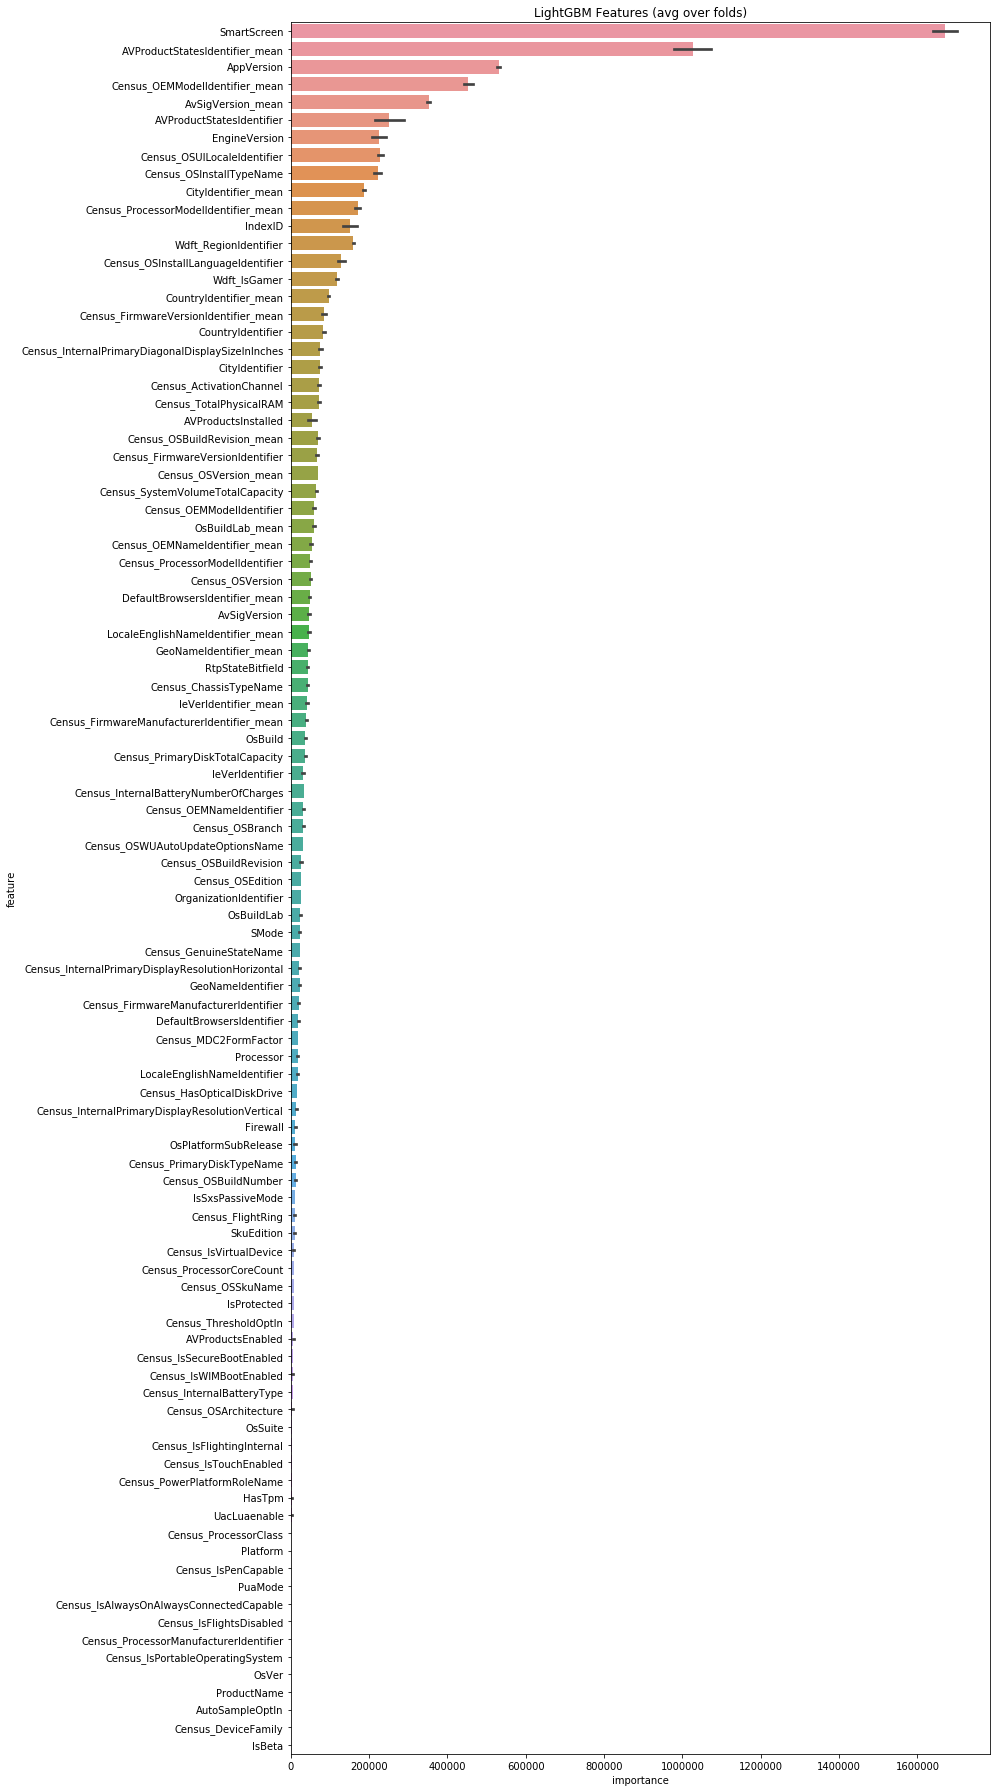

In [40]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

<a id="5"></a> <br>
## 5. Submission

In [41]:
sub_df = pd.DataFrame({"MachineIdentifier": test["MachineIdentifier"].values})
print(len(sub_df))
sub_df["HasDetections"] = predictions

7853253


In [42]:
len(sub_df["HasDetections"])

7853253

In [43]:
from datetime import datetime as dt
score=metrics.roc_auc_score(target, oof)
filename = 'subm_{:.6f}pastfuture{}_{}.csv'.format(score, 'Feature_Encoding_LGBM', dt.now().strftime('%Y-%m-%d-%H-%M'))
sub_df.to_csv(filename, index=False)